# We are not providing you with any code for this assignment, so you must code everything yourself. However, we are providing you with an example notebook on how to run an MCMC.
# Furthermore, we provide a noise-free and noisy reference model from which you must derive parameters. Lastly, we give you three noisy covariance matrices.
# We recommend running the MCMC not in a Jupyter Notebook but instead using an external Python script.

In [14]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import inv
from cosmopower import cosmopower_NN
import tensorflow as tf
import gc

import emcee
import multiprocess as mp
from getdist import plots, MCSamples, parampriors

In [2]:
# This cell is for formatting plots, and can be commented out if it causes problems
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams["font.size"] = 16
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"

In [3]:
cov=np.load('data_4_assignment3/covariance.npy')
cov_inv = inv(cov)

minimum=np.load('data_4_assignment3/minimum.npy')
maximum=np.load('data_4_assignment3/maximum.npy')

reference_model = np.load('data_4_assignment3/reference_model.npy')
reference_model_noisy = np.load('data_4_assignment3/reference_model_noise.npy')

cp_nn_model = cosmopower_NN(restore=True, restore_filename='data_4_assignment3/emulator_final')

cov_num_1500 = np.load('data_4_assignment3/cov_num_1500.npy')
cov_num_3000 = np.load('data_4_assignment3/cov_num_3000.npy')
cov_num_10000 = np.load('data_4_assignment3/cov_num_10000.npy')

## You can use any sampler you like to use for the following tasks. Also, you can use your own emulator. You must use the noisy reference model for the first three tasks. Check for each task that the posteriors and the $\chi^2$ distributions are as expected.
## Your tasks for this week are the following:

### 1. Run an MCMC where you vary all four parameters you have trained on your emulator.

In [5]:
reference_index  = [8000]

parameters = np.load('data_4_assignment2/parameters.npz')
reference_params = {}
for name in parameters.keys():
    reference_params[name]=list(np.array(parameters[name])[reference_index])
  
models = np.load('data_4_assignment2/models.npy')
reference_model = np.load('data_4_assignment2/models.npy')[reference_index][0]


cov=np.load('data_4_assignment1/covariance.npy')
cov_inv = inv(cov)

cp_nn_model = cosmopower_NN(restore=True, restore_filename='data_4_assignment3/emulator_final')

In [18]:
total_steps = 1500 # total  number of steps each walker is doing            (2000)
burning_steps = 500 # how many buring steps you want to remove             (1000)
nwalkers = 10 # Number of walkers that probe the parameter space            (50)

num_threads = 10 # number of cpu cores to use

#which paramters we want to vary
parameters = np.load('data_4_assignment2/parameters.npz')
param_names_varying = ['omega_m', 'omega_b', 'As', 'w'] # alternatively you can also just use parameters.files
ndim = len(param_names_varying)


## a function that distributed start postions inside the trained parameters
def start_position_lh_and_step_size(seed):
    random.seed(seed)
    p0 = []
    for i in range(nwalkers):
        random_starts = []
        
        for name in param_names_varying:
            lower_edge = np.min(parameters[name])
            upper_edge = np.max(parameters[name])
            if(lower_edge<0):
                lower_edge = lower_edge * 0.99
            else:
                lower_edge = lower_edge * 1.01
            if(upper_edge>0):
                upper_edge = upper_edge * 0.99
            else:
                upper_edge = upper_edge * 1.01     
                
            random_starts.append(random.uniform(lower_edge,upper_edge))

        p0.append(random_starts)
        
    return np.array(p0)


## function that computes our priors. Here we only allow the walker to be inside the training range. You can also define Gaussian priors. 
def cal_logprior(para_dict):

    lnprior = 0
    #cosmological priors
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf
    
    return lnprior


## Function that computes the likelihood
def calc_likelihood(para):
    
    #params = {'omega_b':reference_params['omega_b'],'w':reference_params['w']}
    params = reference_params
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector = pred_vector*maximum+minimum 
    
    delta = pred_vector - reference_model
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior

In [19]:
p0 = start_position_lh_and_step_size(0)

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_test_emcee_mine',samples)
log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_test_emcee_mine',log_prob_samples)

100%|██████████| 1500/1500 [02:53<00:00,  8.63it/s]


Removed no burn in


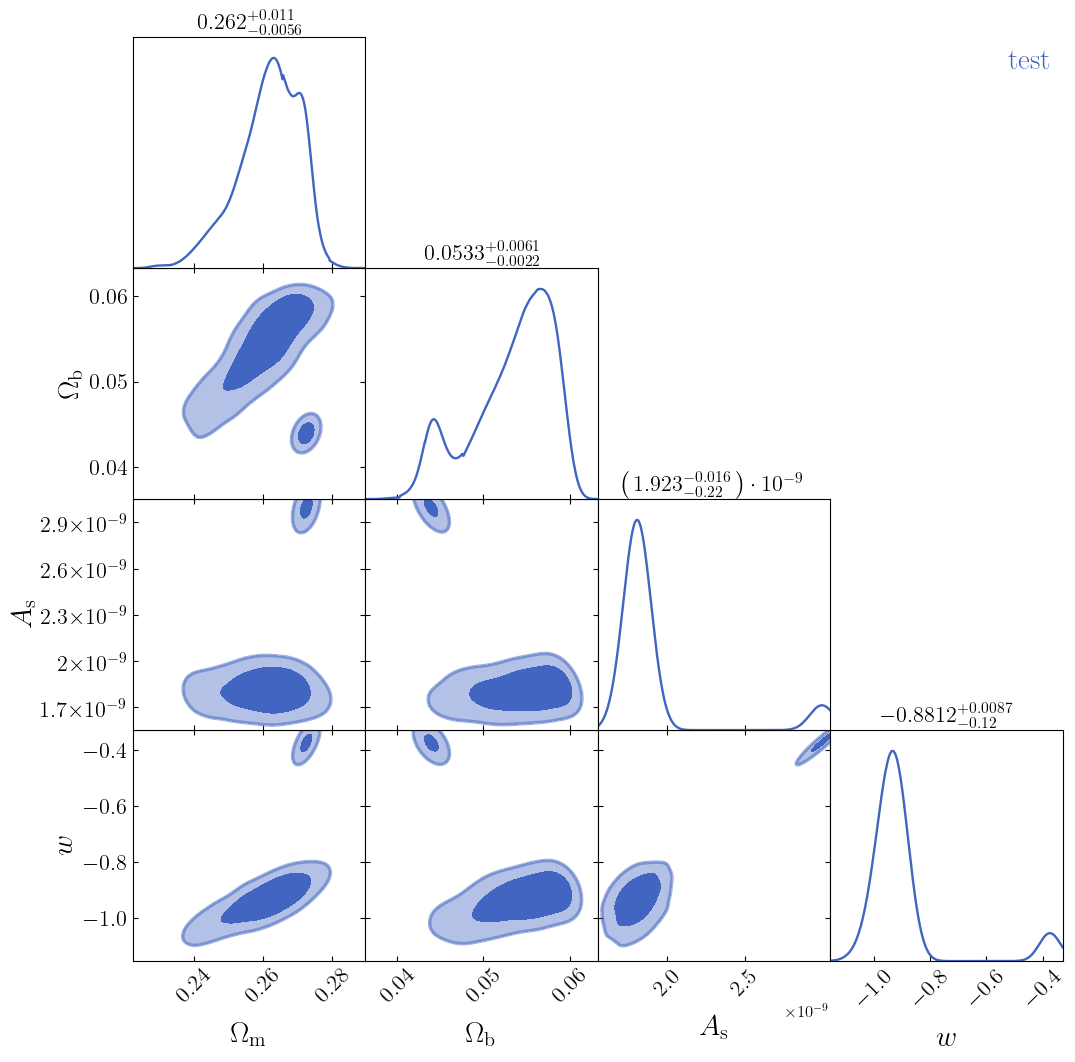

In [20]:
# plot stuff idk

para_names = parameters.keys()
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])

samples_getdist = MCSamples(samples=samples,names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g.triangle_plot(
    roots=[samples_getdist],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['test'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

#plt.savefig('data_4_assignment3/plots/MCMC_test_mine.jpg',dpi=600, bbox_inches='tight')

### 2. Use the provided numerical covariance matrices with [1.5k,3k,10k] data vectors as in assignment one. Run an MCMC for all of them with and without Hartlap correction, and compare with your results. Link your results to assignment one.

### 3. Next, we consider PCA data compression. Run an MCMC for several numbers of PCA elements. Link your results to assignment two.
####    3.a. Use the analytical covariance matrix.
####    3.b. Use the 1.5k covariance matrix. Do you observe the same trend as in 3.a?

### 4. Run task 3 with the noise-free reference model. What difference do you observe in the MCMC chain and the corresponding $\chi^2$ distributions?

#### 4.a Plot and compare the marginalised constraints on $\Omega_\mathrm{m}$ and $A_s$, as a function of the number of PCA elements. What do you observe?
#### 4.b To check if your answer in 4.a is robust, run multiple MCMC chains with the 1.5 covariance matrix and a fixed number of PCA elements. How big are the variations on the marginalised errors on $\Omega_\mathrm{m}$ and $A_s$? Is your answer in 4.a reliable? What can you improve to make 4.a reliable?

### 5. Bonus: Use an MCMC sampler not described in the attached notebook. Compare its performance (speed, accuracy) to the samplers we provided.
###